# **Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"**

## **ID Group**: 07MIAR06 
## **Dataset**: Plant Seedlings Classification

### **Integrantes**: 
### Álvaro Sánchez Rocamora
### Daniel Abellán Sánchez
### Carlos Melgosa Durá


#### El código de la práctica se encuentra en el siguiente repositorio de GitHub: https://github.com/daniabellan/Plant-Seedlings-Classification

## Imports Librerías

In [4]:
import tensorflow as tf
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import numpy as np
import math

from sklearn.utils.class_weight import compute_class_weight

## Descarga de datos desde la plataforma Kaggle

### Para este proyecto se va a hacer uso del dataset de kaggle https://www.kaggle.com/c/plant-seedlings-classification/data

##### En esta ocasión, por dificultades en la descarga directa del dataset desde kaggle, hemos obtado por descargarlo y hacer uso de éste en local.

##### Dentro del repositorio de Github con el código, en la carpeta de *dataset/* disponemo de dos subcarpetas llamadas *test/* y *train/* con las muestras pertinentes a cada partición. Todo esto es respetando la jerarquía original del dataset.

# **1. Carga del conjunto de datos**

### Definimos las funciones necesarias para la carga de los datasets 

In [5]:
# Definimos un diccionario para mapear los nombres de las clases con sus índices
dict_map_class = {
    'Loose Silky-bent': 0,
    'Common Chickweed': 1,
    'Scentless Mayweed': 2,
    'Small-flowered Cranesbill': 3,
    'Fat Hen': 4,
    'Charlock': 5,
    'Sugar beet': 6,
    'Cleavers': 7,
    'Black-grass': 8,
    'Shepherds Purse': 9,
    'Common wheat': 10,
    'Maize': 11,   
}

# Invertimos el diccioanrio del mapeo de clases
dict_map_class_inverted = {v: k for k, v in dict_map_class.items()}


def get_dict_dataset(
    dataset_path: str = 'dataset'
):
    """
    Crea un diccionario que asigna las rutas de las imágenes a tuplas que contienen la clase y la partición.

    Args:
        dataset_path (str): Ruta al directorio del conjunto de datos. Por defecto, es 'dataset'.

    Returns:
        dict: Un diccionario donde las claves son las rutas de las imágenes y los valores son tuplas (clase, partición).
    """

    dict_dataset = {}

    train_classes = os.listdir(os.path.join(dataset_path, 'train'))

    for train_class in train_classes:
        class_path = os.path.join(dataset_path, 'train', train_class)
        train_imgs = os.listdir(class_path)
        
        # Split Train images to a 80% for a Train Split for each class
        for train_img in train_imgs[:int(len(train_imgs)*0.8)]:
            train_img_path = os.path.join(class_path, train_img)
            dict_dataset[train_img_path] = (dict_map_class[train_class], 'Train')

        # Assign the rest 20% to Valid Split for each class
        for valid_img in train_imgs[int(len(train_imgs)*0.8):]:
            valid_img_path = os.path.join(class_path, valid_img)
            dict_dataset[valid_img_path] = (dict_map_class[train_class], 'Valid')

    # Geting Test Images
    test_path = os.path.join(dataset_path, 'test')
    test_imgs = os.listdir(test_path)

    for test_img in test_imgs:
        test_img_path = os.path.join(test_path, test_img)
        dict_dataset[test_img_path] = ("Unkown", 'Test')

    return dict_dataset


def dict2dataframe(
    input_dict: Dict[str, Tuple]
):
    """
    Convierte un diccionario a un DataFrame de pandas con columnas para 'path', 'label', y 'split'.

    Args:
        input_dict (dict): Un diccionario donde las claves son las rutas de las imágenes y los valores son tuplas (etiqueta, división).

    Returns:
        pd.DataFrame: Un DataFrame con columnas 'path', 'label' y 'split'.
    """
    df = pd.DataFrame([(key, values[0], values[1]) for key, values in input_dict.items()], columns=['path', 'label', 'split'])

    # Returns shuffled datasets
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

### Definimos las funciones para la creación del Datset de TensorFlow

In [6]:
def tf_augmenter():
    """
    Devuelve una función de TensorFlow para la aumentación de datos.

    La función devuelta aplica transformaciones aleatorias a las imágenes de entrada,
    incluyendo volteos aleatorios (arriba-abajo y izquierda-derecha), ajustes de brillo aleatorios,
    y ajustes de contraste aleatorios.

    Returns:
        callable: Una función de TensorFlow que toma un número variable de argumentos (tensores)
                  representando el conjunto de datos y aplica aumentación de datos a las imágenes.
    """
    @tf.function
    def f(*dataset):
        output= list(dataset)
        image = output[0]
        
        # De manera probabilística, con 50% de que ocurra, se aplicará
        # una de estas transformaciones
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_up_down(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_left_right(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_brightness(image, 0.15)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.7:
            image = tf.image.random_contrast(image, 0.6, 1.4)

        output[0] = image
        return output
    return f


@tf.function
def load_image(*inputs):
    """
    Función de TensorFlow para cargar una imagen utilizando una función de NumPy.

    Args:
        *inputs: Número variable de tensores de entrada.

    Returns:
        list: Una lista de tensores de salida con la imagen cargada como primer elemento.
    """
    outputs = list(inputs)
    image = tf.numpy_function(load_image_np, [inputs[0]], tf.float32)
    image.set_shape([None, None, 3])
    outputs[0] = image
    
    return outputs


def load_image_np(path):
    """
    Carga una imagen con PIL desde la ruta especificada y la convierte en un array de NumPy.

    Args:
        path (str): La ruta al archivo de la imagen.

    Returns:
        np.ndarray: Un array de NumPy que representa la imagen cargada en formato RGB.
    """
    return np.array(Image.open(path).convert('RGB')).astype(np.float32)


def resize(index=0, resize_to=None):
    """
    Devuelve una función de TensorFlow para cambiar el tamaño de una imagen en un conjunto de datos.

    Args:
        index (int): Índice del tensor de la imagen en el conjunto de datos. Por defecto, es 0.
        resize_to (tuple, list o None): Tamaño objetivo para cambiar el tamaño. Si es None, no se realiza ningún cambio de tamaño. Por defecto, es None.

    Returns:
        callable: Una función de TensorFlow que cambia el tamaño de la imagen en el conjunto de datos.
    """
    def f(*dataset):
        output = list(dataset)
        # Hacemos resize al input size deseado
        resized_image = tf.image.resize(dataset[index], resize_to)
        # Casteamos de nuevo a uint8 para dejar la imagen entre 0 y 255
        resized_image = tf.cast(resized_image, tf.uint8)
        output[index] = resized_image
        
        return output
    return f


def preprocess_input(index):
    """
    Devuelve una función de TensorFlow para preprocesar una imagen en un conjunto de datos.

    Args:
        index (int): Índice del tensor de la imagen en el conjunto de datos.

    Returns:
        callable: Una función de TensorFlow que preprocesa la imagen en el conjunto de datos.
    """
    @tf.function
    def f(*dataset):
        output = list(dataset)
        image = dataset[index]
        # Convertimos a tf.float32 la imagen
        image = tf.cast(image, tf.float32)
        # Normalizamos la imagen entre 0 y 1
        image = image / 255.
        output[index] = image
        
        return output
    return f


def get_dataset(
    df: pd.DataFrame,
    input_size: Tuple[int, int],
    shuffle: bool = False,
    batch_size: int = None,
    gray_scale: bool = False,
    augmenter: bool = False,
    num_aug: int = None,
    test_set: bool = False
)->tf.data.Dataset:
    """
    Crea un dataset de TensorFlow a partir de un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame que contiene información sobre el conjunto de datos.
        input_size (Tuple[int, int]): Tupla que representa el tamaño objetivo para cambiar el tamaño de las imágenes.
        shuffle (bool): Si se debe barajar el conjunto de datos. Por defecto, es False.
        batch_size (int): Tamaño del lote para el conjunto de datos. Si es None, no se realiza agrupamiento. Por defecto, es None.
        gray_scale (bool): Si se deben convertir las imágenes a escala de grises. Por defecto, es False.
        augmenter (bool): Si se debe aplicar aumentación de datos. Por defecto, es False.
        num_aug (int): Número de aumentaciones a aplicar si augmenter es True. Por defecto, es None.
        test_set (bool): Si el conjunto de datos es un conjunto de prueba. Por defecto, es False.

    Returns:
        tf.data.Dataset: Un conjunto de datos de TensorFlow preparado según las opciones proporcionadas.
    """
    # Imprimir información sobre la distribución de las etiquetas
    print('Number of instances per label: ',
          pd.Series(df['label']).value_counts(), sep='\n')
    print('\nPercentaje of instances per label: ',
          pd.Series(df['label']).value_counts().div(pd.Series(df['label']).shape[0]),
          sep='\n')

    names = np.array(df['path'], dtype=str)

    if not test_set:
        labels = np.array(tf.keras.utils.to_categorical(df['label'], num_classes=12))
    else:
        labels = np.ones(len(names))

    data = names, labels

    # Creamos un dataet de TensorFlow a partir de las rutas y etiquetas
    dataset = tf.data.Dataset.from_tensor_slices(data)

    # Barajamos el dataset
    if shuffle:
        print(' > Shuffle')
        dataset = dataset.shuffle(len(names))

    # Cargamos las imagenes
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Aplicamos el resize
    dataset = dataset.map(resize(resize_to=input_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Aumentamos los datos
    if augmenter:
        print(f' > Augmentamos datos numero {num_aug}')
        if num_aug == 1:
            dataset = dataset.map(tf_augmenter(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Preprocesamos las entradas
    dataset = dataset.map(preprocess_input(0), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Convertimos a escala de grises
    if gray_scale:
        print(' > Escala de grises')
        dataset = dataset.map(lambda *args: (tf.image.rgb_to_grayscale(args[0]), *args[1:]))

    # Definimos el batch size
    if batch_size is not None:
        print(' > Establecemos el batchsize')
        dataset = dataset.batch(batch_size)
    
    # Prefetch para paralelizar los siguientes batches mientras se evalua un batch
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

### Cargamos el dataset en un pd.DataFrame y visualizamos los datos

In [7]:
dict_dataset = get_dict_dataset(dataset_path="dataset/")

# Creamos el DataFrame 
df_dataset = dict2dataframe(dict_dataset)
df_dataset

path   label  split
0     dataset/train/Scentless Mayweed/8c496e84a.png       2  Train
1          dataset/train/Common wheat/4a56f32c6.png      10  Train
2                        dataset/test/99569b224.png  Unkown   Test
3           dataset/train/Black-grass/e0380dff9.png       8  Valid
4               dataset/train/Fat Hen/9708f9c0e.png       4  Train
...                                             ...     ...    ...
5539    dataset/train/Shepherds Purse/953ced7c6.png       9  Train
5540                     dataset/test/8cf909eb3.png  Unkown   Test
5541                     dataset/test/98062cd87.png  Unkown   Test
5542                     dataset/test/cc3d2a59a.png  Unkown   Test
5543           dataset/train/Cleavers/b6220c08e.png       7  Train

[5544 rows x 3 columns]

#### En el DataFrame anterior podemos visualizar por cada índice, el path de la imagen junto a su etiqueta asociada y al split que perteneces (Train, Valid o Test).

#### Aquellas imagenes pertenecientes a Test presentan la etiqueta de Unkown. Esto se debe a que el dataset de kaggle no tiene el dataset de test etiquetado, por ello para diferenciarlo aún más le ponemos esta etiqueta.

# **2. Inspección del conjunto de datos**

#### Dado que ya disponemos del DataFrame con todas las muestras, vamos a crear cada partición y a su vez, visualizar las distribuciones de las etiquetas por cada uno de los splits.

In [8]:
# Creamos dataset de Train
df_dataset_train = df_dataset[df_dataset['split'] == 'Train'].drop(columns=['split'])
df_dataset_train

path label
0         dataset/train/Scentless Mayweed/8c496e84a.png     2
1              dataset/train/Common wheat/4a56f32c6.png    10
4                   dataset/train/Fat Hen/9708f9c0e.png     4
5                dataset/train/Sugar beet/6d623072a.png     6
8     dataset/train/Small-flowered Cranesbill/869252...     3
...                                                 ...   ...
5534      dataset/train/Scentless Mayweed/948251df3.png     2
5535             dataset/train/Sugar beet/29a0e6bf9.png     6
5537               dataset/train/Charlock/8b35222d0.png     5
5539        dataset/train/Shepherds Purse/953ced7c6.png     9
5543               dataset/train/Cleavers/b6220c08e.png     7

[3794 rows x 2 columns]

In [9]:
# Visualizamos distribuciones por clase
df_dataset_train['label'].value_counts()

label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

##### Si nos fijamos en la distribución de muestras por clases del splir de train podemos ver como se presenta un desbalanceo de clases notable. Podemos ver como de la clase 0 disponemos de 523 muestras, mientras que de la clase 11 disponemos nomás de 176 muestras.

##### Dado este desbalanceo, se va a obtar por entrenar los modelos pasándoles los pesos de cada una de las clases mediante el netodo *compute_class_weight()* de la librería de *sklearn*.

##### Otra opción era duplicar las muestras de las clases minoritarias e igualar las muestras de la mayoritaria, pero esto supondría la repetición de muchas imágenes iguales y se ha descartado

In [11]:
# Calculamos los pesos de cada clase debido al desbalanceo de las clases
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df_dataset_train['label'].values),
                                     y=df_dataset_train['label'].values
)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.6045251752708731,
 1: 0.6478825136612022,
 2: 0.7673948220064725,
 3: 0.7984006734006734,
 4: 0.8320175438596491,
 5: 1.0133547008547008,
 6: 1.0265151515151516,
 7: 1.3806404657933042,
 8: 1.5055555555555555,
 9: 1.7182971014492754,
 10: 1.7964015151515151,
 11: 1.7964015151515151}

##### Por lo que para calcular los pesos de las clases, que posteriormente se les pasarán en el fit del modelo, se hace uso del siguiente código. 

##### Del resultado podemos ver como las clases minoritarias presentan mayor peso que las que tienen mas presencia en nuestro dataset. Por ello, de las clases con mayor peso, la red ponderará más.

##### Este cálculo de los pesos sólo lo haremos para el set de Train, para los otros no es necesario

In [12]:
# Creamos dataset de Validación
df_dataset_valid = df_dataset[df_dataset['split'] == 'Valid'].drop(columns=['split'])
df_dataset_valid

path label
3               dataset/train/Black-grass/e0380dff9.png     8
10        dataset/train/Scentless Mayweed/d748c7307.png     2
15                  dataset/train/Fat Hen/e6b756e98.png     4
22    dataset/train/Small-flowered Cranesbill/ecf58a...     3
24                 dataset/train/Charlock/d1b362c43.png     5
...                                                 ...   ...
5500       dataset/train/Loose Silky-bent/fc2b27fff.png     0
5501               dataset/train/Charlock/fc3e15a2e.png     5
5503      dataset/train/Scentless Mayweed/d1e775b97.png     2
5505       dataset/train/Common Chickweed/f50c8181a.png     1
5538                  dataset/train/Maize/e30accd2f.png    11

[956 rows x 2 columns]

In [13]:
# Visualizamos distribuciones por clase
df_dataset_valid['label'].value_counts()

label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

In [14]:
# Creamos dataset de Test
df_dataset_test = df_dataset[df_dataset['split'] == 'Test'].drop(columns=['split'])
df_dataset_test

path   label
2     dataset/test/99569b224.png  Unkown
6     dataset/test/d14aa43f3.png  Unkown
7     dataset/test/b47691c08.png  Unkown
12    dataset/test/19fdf19fb.png  Unkown
14    dataset/test/7d4cd07ad.png  Unkown
...                          ...     ...
5526  dataset/test/b30ab4659.png  Unkown
5536  dataset/test/bb1c84bbc.png  Unkown
5540  dataset/test/8cf909eb3.png  Unkown
5541  dataset/test/98062cd87.png  Unkown
5542  dataset/test/cc3d2a59a.png  Unkown

[794 rows x 2 columns]

In [15]:
# Visualizamos distribuciones por clase
df_dataset_test['label'].value_counts()

label
Unkown    794
Name: count, dtype: int64

#### Vistas las distribuciones de muestras por Split, vamos a visualizar unas muestras del Entrenamiento.

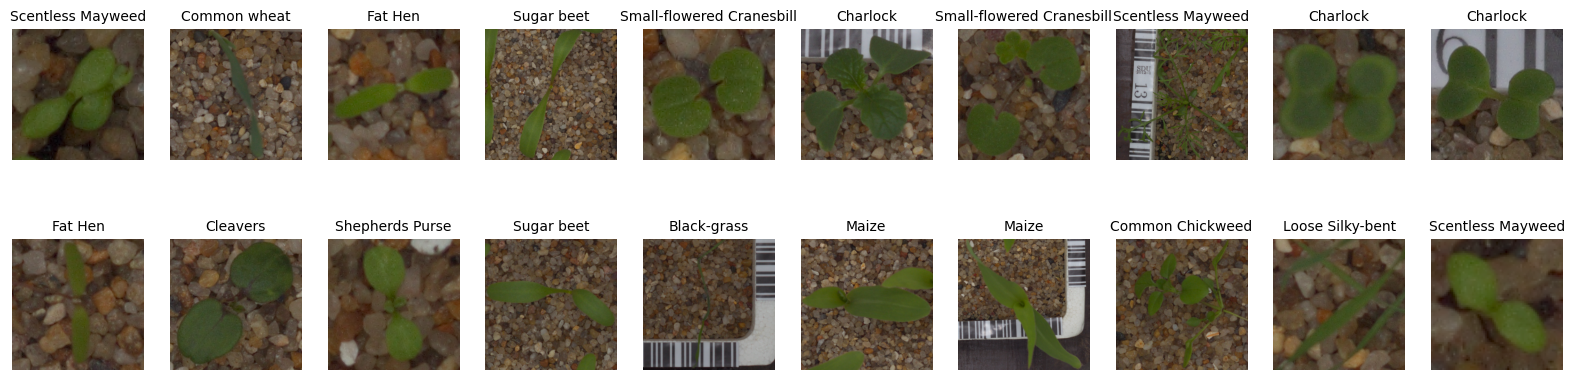

In [16]:
fig = plt.figure(figsize = (20, 5))

for i in range(20):
    img = Image.open(df_dataset_train.iloc[i]['path'])
    ax = fig.add_subplot(2, 10, i + 1)
    ax.imshow(img.convert('RGB'))
    title = dict_map_class_inverted[df_dataset_train.iloc[i]['label']]
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# **3. Acondicionamiento del conjunto de datos**

#### Creados los Splits para el Dataset original, podemos pasar a preparar un ejemplo de los TensorFlow Datasets pertinentes para cada uno de los Splits (Train, Val y Test) que se van a usar para las siguientes pruebas. A su vez, también los visualizaremos para ver qué imagenes entrarían a la red

In [17]:
# Creamos un ejemplo de datastet de train
train_tfdataset = get_dataset(
    df=df_dataset_train,
    input_size=(224,224),
    batch_size=16,
    shuffle=True,
    gray_scale=False,
    augmenter=True,
    num_aug=1,
)

train_tfdataset

Number of instances per label: 
label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137849
1     0.128624
2     0.108593
3     0.104375
4     0.100158
5     0.082235
6     0.081181
7     0.060358
8     0.055351
9     0.048498
10    0.046389
11    0.046389
Name: count, dtype: float64


2023-11-26 13:41:38.436481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 13:41:38.526596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 13:41:38.526808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 13:41:38.532185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 13:41:38.532532: I tensorflow/compile

 > Shuffle
 > Augmentamos datos numero 1
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

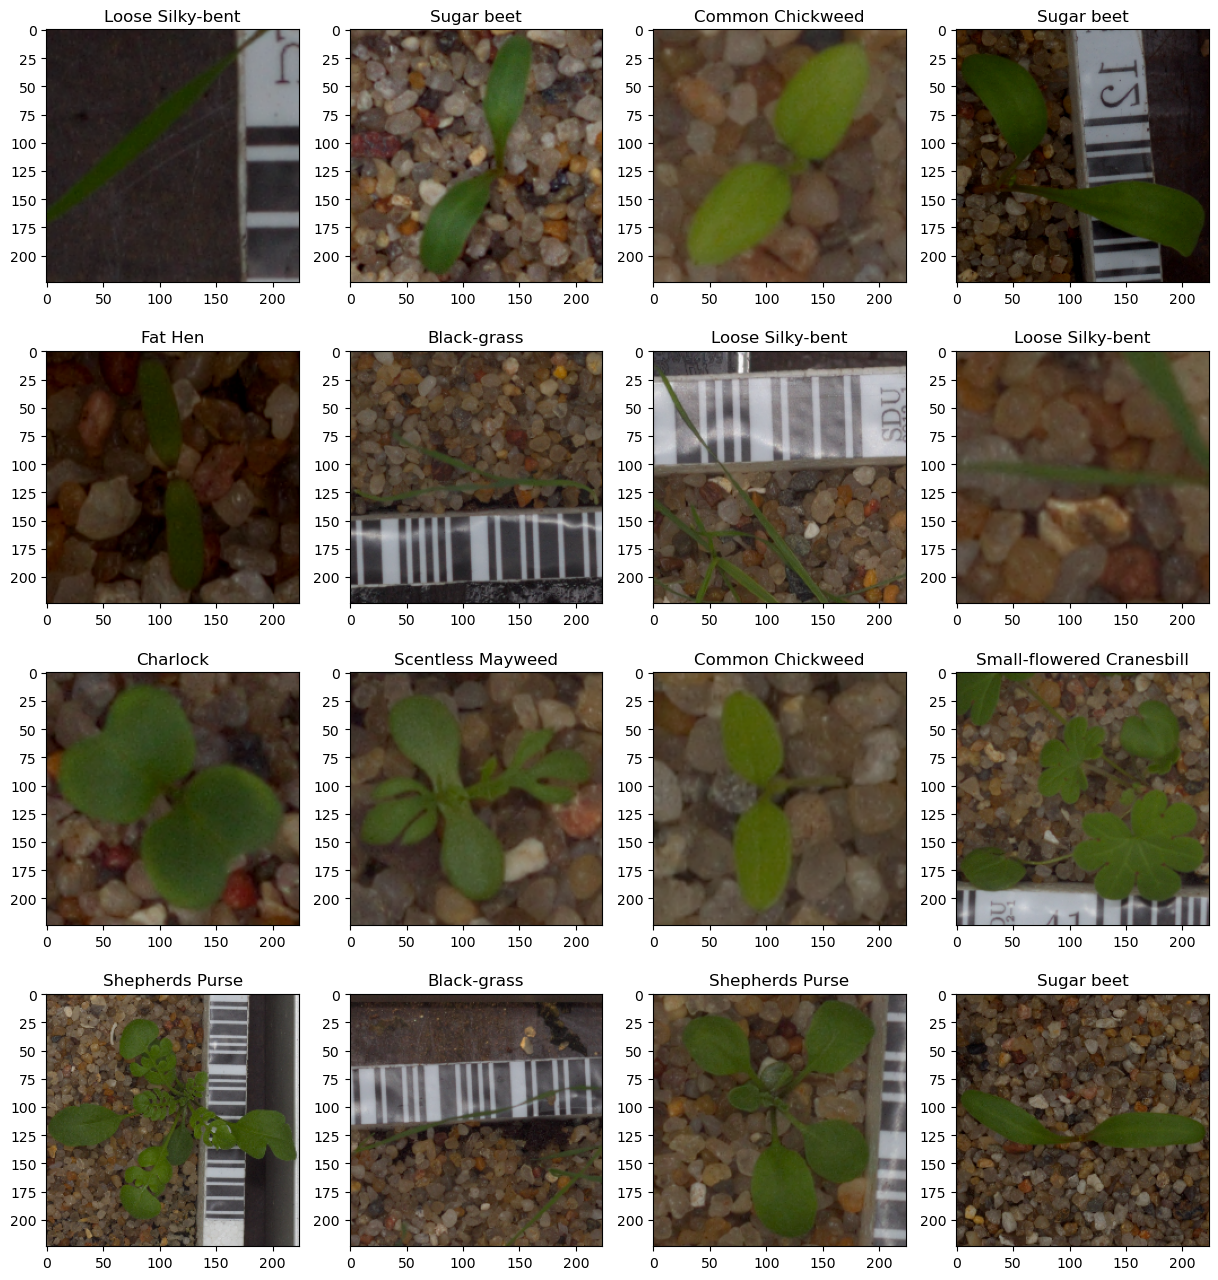

In [18]:
# Visualizamos dataset de Train
batch = next(iter(train_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [19]:
# Creamos un ejemplo de datastet de Validacion
valid_tfdataset = get_dataset(
    df=df_dataset_valid,
    input_size=(224,224),
    batch_size=16,
    shuffle=True,
    gray_scale=False,
    augmenter=False,
)

valid_tfdataset

Number of instances per label: 
label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137029
1     0.128661
2     0.108787
3     0.104603
4     0.099372
5     0.081590
6     0.080544
7     0.060669
8     0.055439
9     0.049163
11    0.047071
10    0.047071
Name: count, dtype: float64
 > Shuffle
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

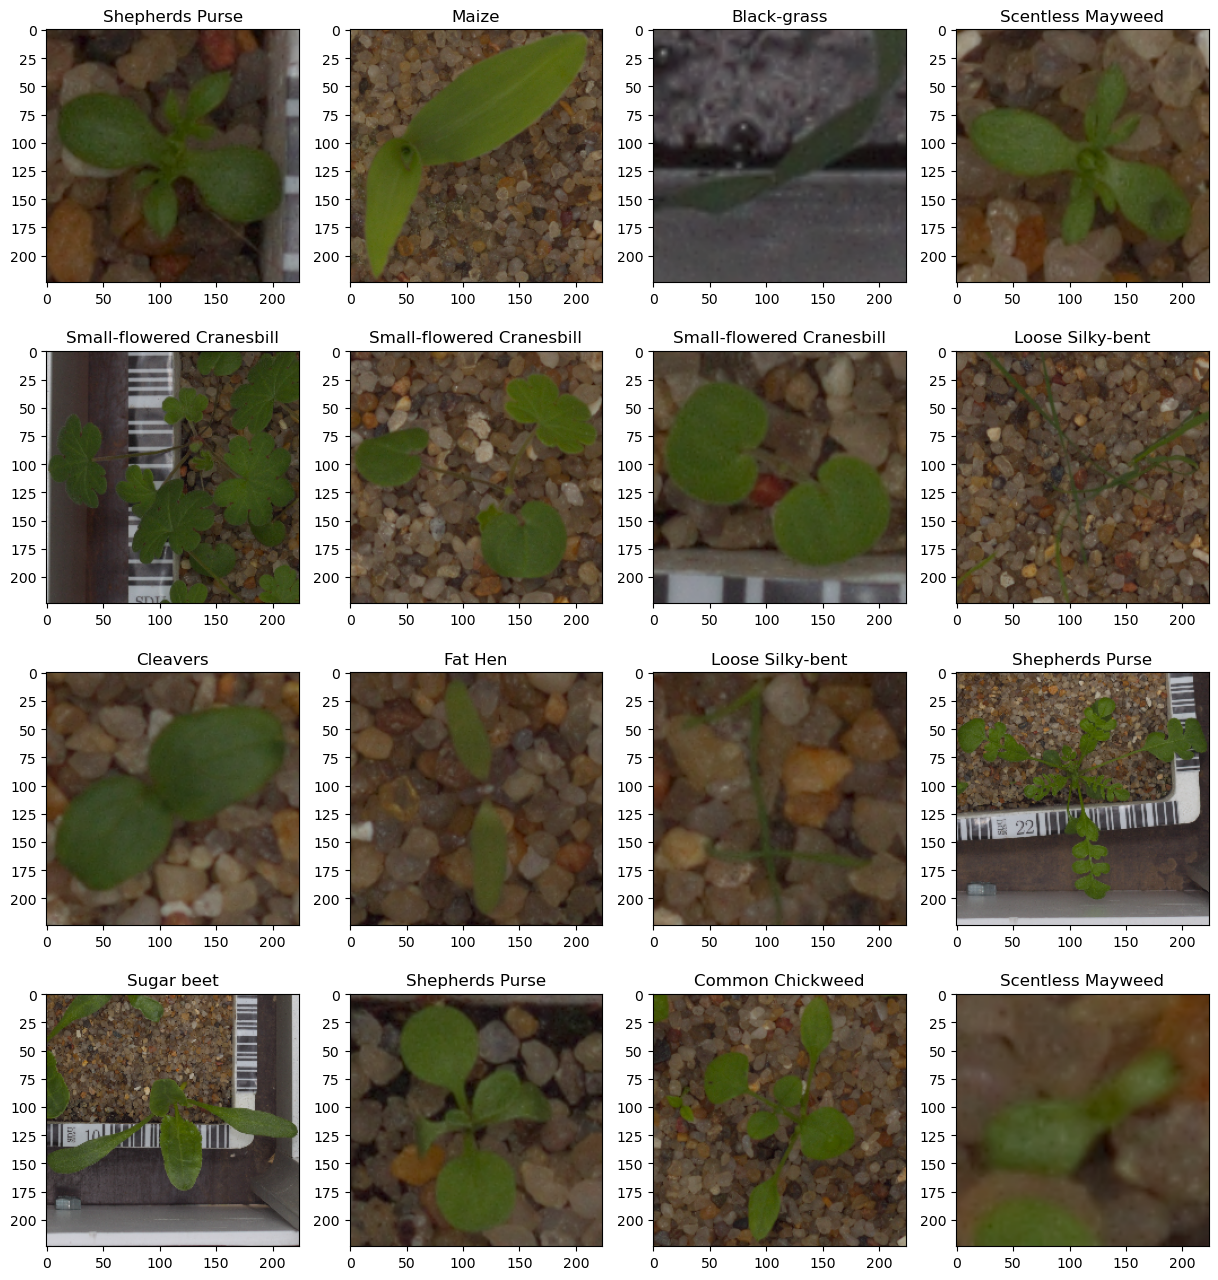

In [20]:
# Visualizamos dataset de Train
batch = next(iter(valid_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [21]:
# Creamos un ejemplo de datastet de test
test_tfdataset = get_dataset(
    df=df_dataset_test,
    input_size=(224,224),
    batch_size=16,
    gray_scale=False,
    augmenter=False,
    test_set=True,
)

test_tfdataset

Number of instances per label: 
label
Unkown    794
Name: count, dtype: int64

Percentaje of instances per label: 
label
Unkown    1.0
Name: count, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

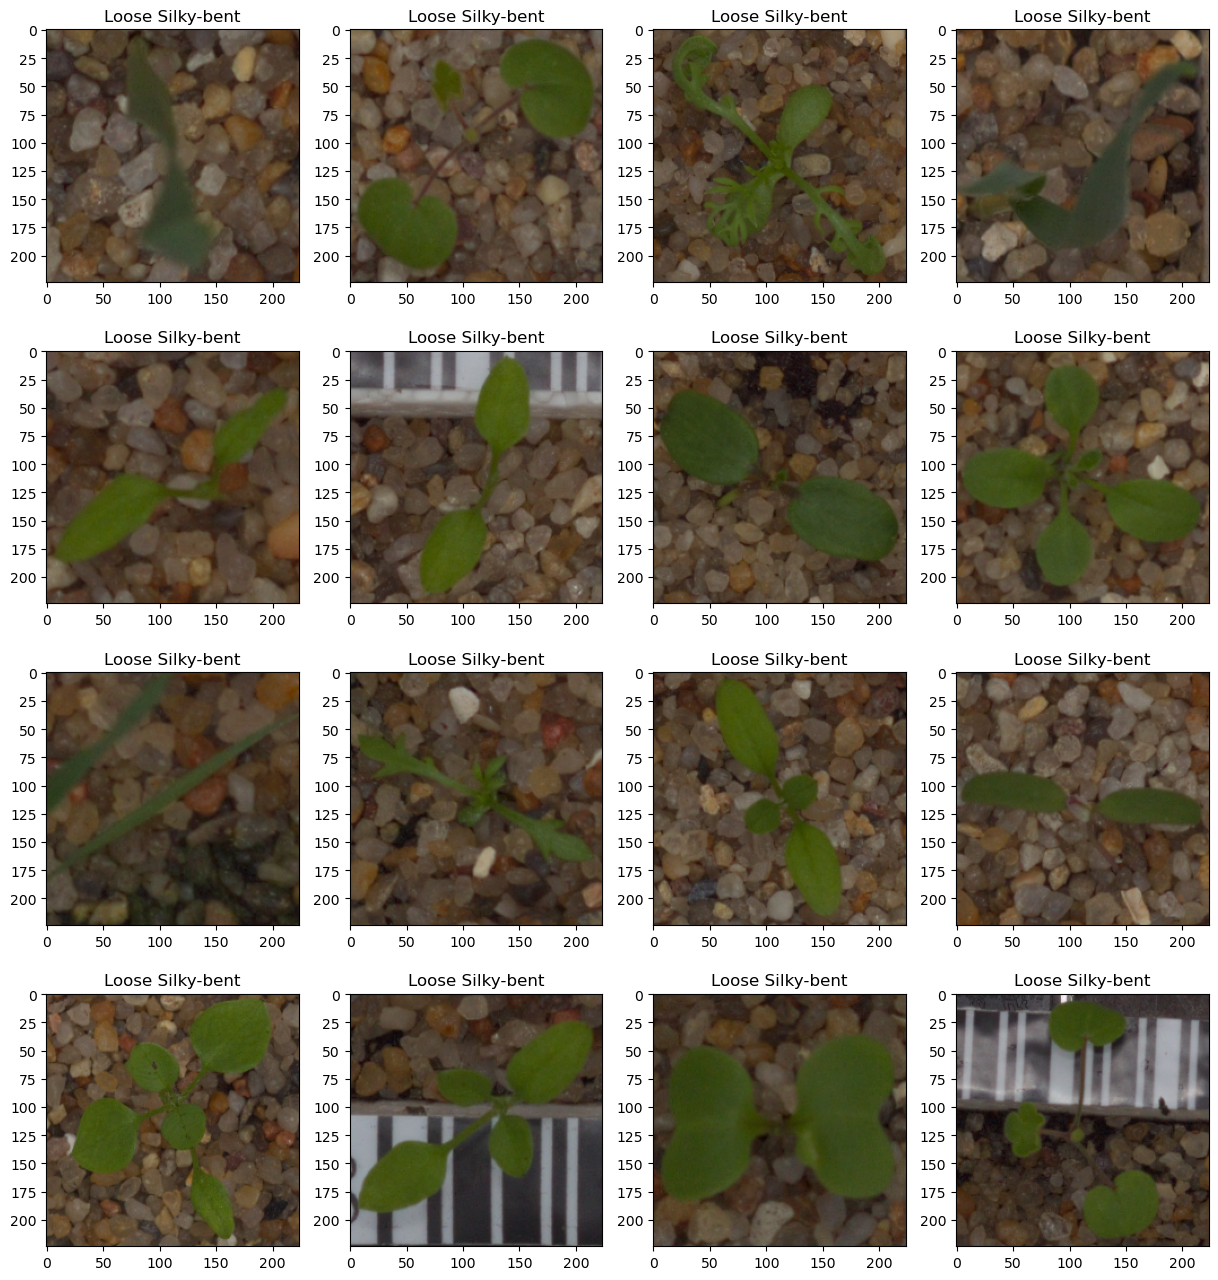

In [22]:
# Visualizamos dataset de Test
batch = next(iter(test_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

# **4.1 Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución (from scratch)**

### Creamos los callbacks

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class HistoryAndPlotCallback(Callback):
    def __init__(self, model_name):
        super(HistoryAndPlotCallback, self).__init__()
        self.model_name = model_name

    def on_train_end(self, logs=None):
        # Guardar el historial del modelo
        history = self.model.history.history

        # Calcular límite eje Y
        loss_av = np.average(history["loss"][-1])
        val_loss_av = np.average(history["val_loss"][-1])
        acc_av = np.average(history["acc"][-1])
        val_acc_av = np.average(history["val_acc"][-1])
        y_upper_limit = np.max([loss_av, val_loss_av, acc_av, val_acc_av])
        y_upper_limit *= 2

        np.save(f'models/{self.model_name}/training_history.npy', history)

        # Guardar métricas y pérdidas en una sola gráfica
        epochs = len(history["loss"])
        
        plt.style.use("ggplot")
        plt.figure(figsize=(12, 8))
        plt.plot(np.arange(0, epochs), history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history["acc"], label="train_acc")
        plt.plot(np.arange(0, epochs), history["val_acc"], label="val_acc")
        
        plt.title(f"Training Loss and Accuracy - {self.model_name}")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc='upper left')
        plt.ylim(0, int(y_upper_limit))
        plt.grid(True)
        
        # Guardar la gráfica
        plt.savefig(f'models/{self.model_name}/training_plot.png')
        plt.close()

        # Guardar history para revisar en el futuro por si se activa un earlystopping o cualquier problema
        pd.DataFrame.from_dict(history).to_csv(f'models/{self.model_name}/history.csv', index=False)


def get_callbacks(model_name):
    callbacks = [
        EarlyStopping(
            monitor = 'val_loss', 
            mode = 'min', 
            patience = 20, 
            verbose=1,
            restore_best_weights=False),
        ModelCheckpoint(
            filepath = f'models/{model_name}',
            monitor = 'val_loss',
            mode = 'min',
            save_best_only = True,
            verbose = 1),
        HistoryAndPlotCallback(model_name),

    ]
        
    return callbacks

### Creamos los datasets para train, val y test

In [23]:
print("Dataset Train (TensorFlow):")

train_tfdataset = get_dataset(
    df=df_dataset_train,
    input_size=(224,224),
    batch_size=32,
    shuffle=True,
    gray_scale=False,
    augmenter=True,
    num_aug=1,
)
train_tfdataset

Dataset Train (TensorFlow):
Number of instances per label: 
label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137849
1     0.128624
2     0.108593
3     0.104375
4     0.100158
5     0.082235
6     0.081181
7     0.060358
8     0.055351
9     0.048498
10    0.046389
11    0.046389
Name: count, dtype: float64
 > Shuffle
 > Augmentamos datos numero 1
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [24]:
print("Dataset Valid (TensorFlow):")

valid_tfdataset = get_dataset(
    df=df_dataset_valid,
    input_size=(224,224),
    batch_size=32,
    shuffle=True,
    gray_scale=False,
    augmenter=False,
)

valid_tfdataset

Dataset Valid (TensorFlow):
Number of instances per label: 
label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137029
1     0.128661
2     0.108787
3     0.104603
4     0.099372
5     0.081590
6     0.080544
7     0.060669
8     0.055439
9     0.049163
11    0.047071
10    0.047071
Name: count, dtype: float64
 > Shuffle
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [25]:
print("Dataset Test (TensorFlow):")

test_tfdataset = get_dataset(
    df=df_dataset_test,
    input_size=(224,224),
    batch_size=32,
    gray_scale=False,
    augmenter=False,
    test_set=True,
)

test_tfdataset

Dataset Test (TensorFlow):
Number of instances per label: 
label
Unkown    794
Name: count, dtype: int64

Percentaje of instances per label: 
label
Unkown    1.0
Name: count, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Función para lanzar factoría de modelos from scratch
En este bucle se carga la factoría de modelos from scratch para ir probando cada uno y guardando sus resultados con los callbacks personalizados. Las configuraciones de los modelos vienen desde el archivo "scratch_configs/scratch_experiments.json". Estas configuraciones se pasan a la factoría y se crean los modelos.

In [ ]:
# model_factory
from tensorflow.keras import models, layers

class ConvBlockConfig:
    def __init__(self, filters, kernel_size, use_maxpooling=True, use_batchnorm=True, dropout_value=0, name=None):
        """Configuracion de cada bloque con los parametros que vienen del json

        Args:
            filters (_type_): Numero de filtros del bloque (una capa convolucional por bloque)
            kernel_size (_type_): Tamaño del kernel de la capa convolucional
            use_maxpooling (bool, optional): Usar regularizacion MaxPooling. Defaults to True.
            use_batchnorm (bool, optional): Usar regularizacion BatchNorm. Defaults to True.
            dropout_value (int, optional): Usar regularizacion Dropout. Defaults to 0.
            name (_type_, optional): Nombre del bloque. Defaults to None.
        """
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_maxpooling = use_maxpooling
        self.use_batchnorm = use_batchnorm
        self.dropout_value = dropout_value
        self.name = name

def create_conv_block(config, input_shape):
    """Crea los bloques convolucionales con sus regularizaciones (MaxPooling, BatchNorm y Dropout)

    Args:
        config (_type_): Configuracion de cada bloque (viene del json de experimentos)
        input_shape (_type_): Tamaño de entrada del bloque

    Returns:
        _type_: Bloque convolucional
    """
    # Creacion del modelo
    block = models.Sequential(name=config.name)
    
    # CNN input 
    block.add(layers.Conv2D(config.filters, config.kernel_size, activation='relu', padding='same', input_shape=input_shape))
    
    # Regularizacion
    if config.use_batchnorm:
        block.add(layers.BatchNormalization(name=f'{config.name}_batchnorm'))
    
    if config.use_maxpooling:
        block.add(layers.MaxPooling2D((2, 2), name=f'{config.name}_maxpooling'))
    
    if config.dropout_value > 0:
        block.add(layers.Dropout(config.dropout_value))
    
    return block

def create_model_with_configurations(conv_block_configs, input_shape, num_classes):
    """Crea el modelo en base a los bloques que le hemos pasado con la configuracion de los experimentos

    Args:
        conv_block_configs (_type_): Configuracion de los bloques
        input_shape (_type_): Dimensiones de entrada
        num_classes (_type_): Numeros de clases para la capa de salida

    Returns:
        _type_: Modelo
    """
    model = models.Sequential()
    
    # Incluimos la capa de entrada directamente en el modelo principal
    model.add(layers.InputLayer(input_shape=input_shape, name='input'))
    
    # Creacion de los bloques para la extraccion de caracteristicas
    for i, config in enumerate(conv_block_configs, start=1):
        block = create_conv_block(config, input_shape)
        model.add(block)
        input_shape = (input_shape[0]//2, input_shape[1]//2, config.filters)  # Ajustamos input_shape después de MaxPooling
    
    # Creacion del top model para obtener la clase
    model.add(layers.Flatten(name='top_model_flatten'))
    model.add(layers.Dense(128, activation='relu', name='top_model_dense_1'))
    #model.add(layers.Dropout(0.5, name='top_model_dropout')) # Opcional
    model.add(layers.Dense(num_classes, activation='softmax', name='top_model_output'))
    
    return model

In [40]:
def scratch_train(input_shape, experiment_config:dict):
    # Crear modelo, compilarlo y entrenarlo
    for experiment_name, config in experiment_config.items():
        print(f"Running Experiment: {experiment_name}")

        # Configurar el modelo utilizando las configuraciones
        block_configs = []
        for block_conf in config["model"]["conv_block_configs"]:
            block = ConvBlockConfig(block_conf["filters"], 
                                    block_conf["kernel_size"], 
                                    block_conf["use_maxpooling"],
                                    block_conf["use_batchnorm"],
                                    block_conf["dropout_value"],
                                    block_conf["name"])
            block_configs.append(block)
        
        # Crear modelo
        model = create_model_with_configurations(block_configs, input_shape, num_classes)
        
        # Compilar modelo
        model.compile(
            loss = tf.keras.losses.categorical_crossentropy,
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['acc']) 
        
        # Crear callbacks
        callbacks = get_callbacks(experiment_name)

        # Mostrar arquitectura
        print(model.summary())

        # Entrenar modelo
        history = model.fit(train_tfdataset.repeat(),
                            validation_data=valid_tfdataset,
                            class_weight = class_weight_dict,
                            epochs = config["training"]["epochs"],
                            steps_per_epoch=config["training"]["steps_per_epoch"],
                            callbacks = callbacks,
                            verbose=1)
        


# **5.1 Monitorización del proceso de entrenamiento para la toma de decisiones (from scratch)**


### Lanzar entrenamiento from scratch
Usando la configuración de los modelos de la factoría, se lanzan todos los experimentos. De esta manera se ejecutan uno detrás de otro sin necesidad de estar pendiente de lanzarlos manualmente.
La configuración de todos los experimentos se detalla a continuación:

In [32]:
# Configuración experimentos
scratch_experiments = {
    "model1": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block2"
                },
                
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block3"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },
    
    "model1_nobatchnorm": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block2"},
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block3"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },
    
    "model2": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block1"},
                {
                    "filters": 128, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block2"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },

    "model2_nobatchnorm": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block1"},
                {
                    "filters": 128, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block2"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },

    "model3": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block2"
                },
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block3"
                },
                {
                    "filters": 512, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block4"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },

    "model3_nobatchnorm": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block2"
                },
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block3"
                },
                {
                    "filters": 512, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block4"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    }
  }
  

In [41]:
# Dimensiones de entrada
input_shape = (224, 224, 3)

# Número de clases
num_classes = df_dataset_train["label"].max() + 1

# Lanzar entrenamiento
scratch_train(input_shape, scratch_experiments)

Running Experiment: model1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      2048      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       74368     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       296192    
                                                                 
 top_model_flatten (Flatten  (None, 200704)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               25690240  
                                                                 
 top_model_output (Dense)    (None, 12)                1548      
                           

2023-11-26 13:49:57.936196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/block1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-26 13:49:58.744038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 13:50:00.026587: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 13:50:01.172405: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 13:50:02.452448: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8da9087ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 13:50:02.452502: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080

32/32 [==============================] - ETA: 0s - loss: 5.0515 - acc: 0.2051
Epoch 1: val_loss improved from inf to 11.17971, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 28s 591ms/step - loss: 5.0515 - acc: 0.2051 - val_loss: 11.1797 - val_acc: 0.1370
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.1753 - acc: 0.2988
Epoch 2: val_loss did not improve from 11.17971
32/32 [==============================] - 12s 364ms/step - loss: 2.1753 - acc: 0.2988 - val_loss: 20.0213 - val_acc: 0.1360
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.0125 - acc: 0.3271
Epoch 3: val_loss did not improve from 11.17971
32/32 [==============================] - 11s 361ms/step - loss: 2.0125 - acc: 0.3271 - val_loss: 26.5349 - val_acc: 0.0554
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 1.9071 - acc: 0.3525
Epoch 4: val_loss did not improve from 11.17971
32/32 [==============================] - 9s 293ms/step - loss: 1.9071 - acc: 0.3525 - val_loss: 28.1749 - val_acc: 0.0554
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 1.8066 - acc: 0.4121
Epoch 5: 

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 14s 434ms/step - loss: 1.5008 - acc: 0.5254 - val_loss: 9.3637 - val_acc: 0.0659
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 1.4261 - acc: 0.5068
Epoch 11: val_loss improved from 9.36367 to 6.82287, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 400ms/step - loss: 1.4261 - acc: 0.5068 - val_loss: 6.8229 - val_acc: 0.0732
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.2680 - acc: 0.5812
Epoch 12: val_loss improved from 6.82287 to 3.15697, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 414ms/step - loss: 1.2680 - acc: 0.5812 - val_loss: 3.1570 - val_acc: 0.2029
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 1.3444 - acc: 0.5430
Epoch 13: val_loss did not improve from 3.15697
32/32 [==============================] - 9s 278ms/step - loss: 1.3444 - acc: 0.5430 - val_loss: 3.1841 - val_acc: 0.2071
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 1.2846 - acc: 0.5498
Epoch 14: val_loss improved from 3.15697 to 2.98271, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 396ms/step - loss: 1.2846 - acc: 0.5498 - val_loss: 2.9827 - val_acc: 0.2197
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 1.3506 - acc: 0.5436
Epoch 15: val_loss improved from 2.98271 to 2.64963, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 396ms/step - loss: 1.3506 - acc: 0.5436 - val_loss: 2.6496 - val_acc: 0.2762
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 1.2075 - acc: 0.5869
Epoch 16: val_loss did not improve from 2.64963
32/32 [==============================] - 10s 321ms/step - loss: 1.2075 - acc: 0.5869 - val_loss: 2.6850 - val_acc: 0.3316
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 1.1753 - acc: 0.6074
Epoch 17: val_loss improved from 2.64963 to 1.95451, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 14s 461ms/step - loss: 1.1753 - acc: 0.6074 - val_loss: 1.9545 - val_acc: 0.4320
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 1.1432 - acc: 0.6260
Epoch 18: val_loss improved from 1.95451 to 1.87805, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 414ms/step - loss: 1.1432 - acc: 0.6260 - val_loss: 1.8781 - val_acc: 0.4592
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 1.2292 - acc: 0.5832
Epoch 19: val_loss improved from 1.87805 to 1.45024, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 420ms/step - loss: 1.2292 - acc: 0.5832 - val_loss: 1.4502 - val_acc: 0.5199
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 1.0807 - acc: 0.6572
Epoch 20: val_loss improved from 1.45024 to 1.33170, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 14s 452ms/step - loss: 1.0807 - acc: 0.6572 - val_loss: 1.3317 - val_acc: 0.5931
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 1.0692 - acc: 0.6318
Epoch 21: val_loss did not improve from 1.33170
32/32 [==============================] - 10s 311ms/step - loss: 1.0692 - acc: 0.6318 - val_loss: 1.3931 - val_acc: 0.5931
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.1003 - acc: 0.6299
Epoch 22: val_loss improved from 1.33170 to 1.30623, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 399ms/step - loss: 1.1003 - acc: 0.6299 - val_loss: 1.3062 - val_acc: 0.5753
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 1.0381 - acc: 0.6465
Epoch 23: val_loss did not improve from 1.30623
32/32 [==============================] - 10s 324ms/step - loss: 1.0381 - acc: 0.6465 - val_loss: 1.4312 - val_acc: 0.5638
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 1.0006 - acc: 0.6602
Epoch 24: val_loss improved from 1.30623 to 1.18148, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 427ms/step - loss: 1.0006 - acc: 0.6602 - val_loss: 1.1815 - val_acc: 0.6506
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.8783 - acc: 0.6807
Epoch 25: val_loss improved from 1.18148 to 1.09370, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 14s 433ms/step - loss: 0.8783 - acc: 0.6807 - val_loss: 1.0937 - val_acc: 0.6433
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.9310 - acc: 0.6758
Epoch 26: val_loss did not improve from 1.09370
32/32 [==============================] - 10s 306ms/step - loss: 0.9310 - acc: 0.6758 - val_loss: 1.1134 - val_acc: 0.6297
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.7915 - acc: 0.7416
Epoch 27: val_loss improved from 1.09370 to 1.05354, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 14s 448ms/step - loss: 0.7915 - acc: 0.7416 - val_loss: 1.0535 - val_acc: 0.6726
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 0.8577 - acc: 0.7168
Epoch 28: val_loss improved from 1.05354 to 0.95128, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 14s 434ms/step - loss: 0.8577 - acc: 0.7168 - val_loss: 0.9513 - val_acc: 0.6977
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.8409 - acc: 0.7109
Epoch 29: val_loss did not improve from 0.95128
32/32 [==============================] - 10s 321ms/step - loss: 0.8409 - acc: 0.7109 - val_loss: 0.9718 - val_acc: 0.6956
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.8767 - acc: 0.6891
Epoch 30: val_loss did not improve from 0.95128
32/32 [==============================] - 10s 308ms/step - loss: 0.8767 - acc: 0.6891 - val_loss: 1.2682 - val_acc: 0.6203
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.7300 - acc: 0.7676
Epoch 31: val_loss did not improve from 0.95128
32/32 [==============================] - 11s 335ms/step - loss: 0.7300 - acc: 0.7676 - val_loss: 1.1162 - val_acc: 0.7144
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.7215 - acc: 0.7666
Epoch 32

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 14s 451ms/step - loss: 0.7215 - acc: 0.7666 - val_loss: 0.9502 - val_acc: 0.7238
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.7438 - acc: 0.7383
Epoch 33: val_loss did not improve from 0.95021
32/32 [==============================] - 10s 329ms/step - loss: 0.7438 - acc: 0.7383 - val_loss: 1.0197 - val_acc: 0.6799
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.7195 - acc: 0.7505
Epoch 34: val_loss did not improve from 0.95021
32/32 [==============================] - 10s 311ms/step - loss: 0.7195 - acc: 0.7505 - val_loss: 0.9642 - val_acc: 0.7040
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.6810 - acc: 0.7510
Epoch 35: val_loss did not improve from 0.95021
32/32 [==============================] - 11s 337ms/step - loss: 0.6810 - acc: 0.7510 - val_loss: 0.9691 - val_acc: 0.7197
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.7719 - acc: 0.7373
Epoch 36

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 415ms/step - loss: 0.7719 - acc: 0.7373 - val_loss: 0.9274 - val_acc: 0.7040
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.6882 - acc: 0.7666
Epoch 37: val_loss did not improve from 0.92744
32/32 [==============================] - 9s 271ms/step - loss: 0.6882 - acc: 0.7666 - val_loss: 1.0021 - val_acc: 0.7061
Epoch 38/50
32/32 [==============================] - ETA: 0s - loss: 0.6887 - acc: 0.7604
Epoch 38: val_loss did not improve from 0.92744
32/32 [==============================] - 11s 358ms/step - loss: 0.6887 - acc: 0.7604 - val_loss: 1.0729 - val_acc: 0.6925
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.6550 - acc: 0.7881
Epoch 39: val_loss did not improve from 0.92744
32/32 [==============================] - 10s 312ms/step - loss: 0.6550 - acc: 0.7881 - val_loss: 1.0170 - val_acc: 0.7082
Epoch 40/50
32/32 [==============================] - ETA: 0s - loss: 0.6262 - acc: 0.8105
Epoch 40:

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 413ms/step - loss: 0.6262 - acc: 0.8105 - val_loss: 0.8969 - val_acc: 0.7186
Epoch 41/50
32/32 [==============================] - ETA: 0s - loss: 0.5518 - acc: 0.8059

KeyboardInterrupt: 

# **5.2 Monitorización del proceso de entrenamiento para la toma de decisiones (pre-entrenada)**

### **DenseNet**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


# Tamaño entrada
input_shape = (224, 224, 3)

# Callbacks y guardado de grádicas
callbacks = get_callbacks("DenseNet121")

    
# Cargar el modelo preentrenado de DenseNet121 sin incluir las capas densas (fully connected)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Crear un nuevo modelo Sequential
model = Sequential()

# Agregar la base preentrenada de DenseNet121
model.add(base_model)

# Añadir capas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))  

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Mostrar la arquitectura del modelo
model.summary()

history = model.fit(
    train_tfdataset.repeat(),
    steps_per_epoch = 32,
    epochs = 50,  
    validation_data = valid_tfdataset,
    callbacks = callbacks
    )

### **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16


# Tamaño entrada
input_shape = (224, 224, 3)

# Callbacks y guardado de grádicas
callbacks = get_callbacks("VGG16")

    
# Cargar el modelo preentrenado de DenseNet121 sin incluir las capas densas (fully connected)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Crear un nuevo modelo Sequential
model = Sequential()

# Agregar la base preentrenada de VGG16
model.add(base_model)

# Añadir capas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))  

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Mostrar la arquitectura del modelo
model.summary()

history = model.fit(
    train_tfdataset.repeat(),
    steps_per_epoch = 32,
    epochs = 50,  
    validation_data = valid_tfdataset,
    callbacks = callbacks
    )

# **6.1 Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental (from scratch)**


## Estrategia 1: Entrenar desde cero o from scratch

Para realizar esta parte de la práctica se han utilizado un total de 6 arquitecturas diferentes. Para hacer experimentos comparativos y poder ver cómo afectan las técnicas de regularización a las arquitecturas, todas tienen el mismo top model para hacer la clasificación y comparten algunos métodos de regularización que se mantienen a lo largo de todas las arquitecturas.

Se definen ciertos parámetros comunes en todos los experimentos:

### Hiperparámetros de entrenamiento:
- Paso por época: 32
- Épocas: 50

### Top model:
- Capa densa de 128 unidades y activación ReLU
- Capa de salida con activación softmax para la clasificación multiclase

### Class Weights:
El dataset tiene un desequilibrio elevado en las clases y por lo tanto, se puede producir un sesgo en el entrenamiento. Para poder evitarlo, se ha aplicado a cada entrenamiento el parámetro "class_weights" de SkLearn. Al hacer esto, se le aplican diferentes pesos a las clases en la función de pérdidas durante el entrenamiento.

A continuación, se describen las arquitecturas utilizadas junto con su nombre:

### Model1:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout y Batch Normalization en todas las capas convolucionales

### Model1_nobatchnorm:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout en todas las capas convolucionales

### Model2:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 5x5, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 2: 128 filtros, kernel 5x5, Maxpooling 2x2, Batch Normalization, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout y Batch Normalization en todas las capas convolucionales

### Model2_nobatchnorm:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 5x5, Maxpooling 2x2, Dropout (0.1)
- Block 2: 128 filtros, kernel 5x5, Maxpooling 2x2, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout en todas las capas convolucionales

### Model3:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 4: 512 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout y Batch Normalization en todas las capas convolucionales

### Model3_nobatchnorm:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 4: 512 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout en todas las capas convolucionales

### Análisis de resultados:
Se puede observar que el Model3 con Batch Normalization tiene unas métricas mejores que el resto de modelos. Esto se puede deber tanto a la propia regularización de la red como al hecho de que tiene más número de parámetros. 
Al no tener un dataset de test con etiquetas, no podemos comprobar la fiabilidad de las métricas fuera del entrenamiento.


# **6.2 Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental (pre-entrenada)**

Para realizar una comparación de los modelos vamos a observar las curvas de la función de pérdida y la precisión.

<img src="models\DenseNet121_128\training_plot.png">

<img src="models\VGG16_128\training_plot.png">

DenseNet utiliza conexiones densas entre capas, lo que significa que cada capa recibe información directa de todas las capas anteriores. Esto fomenta la reutilización eficiente de las características extraídas en todas las capas de la red, promoviendo una mayor capacidad de aprendizaje. En cambio, VGG16 utiliza capas completamente conectadas al final, que no comparten información de manera tan eficiente entre capas, lo que podría resultar en una representación menos rica de las características.

Además, DenseNet a menudo requiere menos parámetros que VGG16 para lograr un rendimiento similar, lo que puede hacer que sea más eficiente en términos de memoria y computación.

Tras observar las gráficas observamos que obtenemos un mejor resultado con DenseNet.